In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


In [3]:
# load cifar10 dataset

batch_size = 64
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=ToTensor())
testset = datasets.CIFAR10(root='./data', train=False,download=True, transform=ToTensor())

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# create custom CNN model

class CustomCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1, padding_mode='replicate')
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, padding_mode='replicate')
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, padding_mode='replicate')
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.fc1(x))
        logits = F.softmax(self.fc2(x),dim=0)
        return logits


model = CustomCNN().to(device)
print(model)

CustomCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=replicate)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=replicate)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=replicate)
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)


In [5]:
# chosse loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)

In [6]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    train_loss, correct = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        if batch % 100 == 1:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    train_loss /= size
    correct /= size
    
    return (train_loss,correct)

In [7]:
def test(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    
    return (test_loss, correct)

In [8]:
epochs = 200
loss_values, val_loss_values = [],[]
acc_values, val_acc_values = [],[]

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    (train_loss, train_correct) = train(trainloader, model, loss_fn, optimizer)
    (test_loss, test_correct) = test(testloader, model)
    
    loss_values.append(train_loss)
    val_loss_values.append(test_loss)
    acc_values.append(train_correct)
    val_acc_values.append(test_correct)
    
print("Done!")

Epoch 1
-------------------------------
loss: 2.302591  [   64/50000]
loss: 2.302579  [ 6464/50000]
loss: 2.302588  [12864/50000]
loss: 2.302584  [19264/50000]
loss: 2.302562  [25664/50000]
loss: 2.302580  [32064/50000]
loss: 2.302574  [38464/50000]
loss: 2.302573  [44864/50000]
Test Error: 
 Accuracy: 15.3%, Avg loss: 0.036150 

Epoch 2
-------------------------------
loss: 2.302572  [   64/50000]
loss: 2.302572  [ 6464/50000]
loss: 2.302535  [12864/50000]
loss: 2.302565  [19264/50000]
loss: 2.302546  [25664/50000]
loss: 2.302562  [32064/50000]
loss: 2.302564  [38464/50000]
loss: 2.302553  [44864/50000]
Test Error: 
 Accuracy: 18.8%, Avg loss: 0.036150 

Epoch 3
-------------------------------
loss: 2.302547  [   64/50000]
loss: 2.302551  [ 6464/50000]
loss: 2.302546  [12864/50000]
loss: 2.302554  [19264/50000]
loss: 2.302540  [25664/50000]
loss: 2.302537  [32064/50000]
loss: 2.302540  [38464/50000]
loss: 2.302544  [44864/50000]
Test Error: 
 Accuracy: 21.5%, Avg loss: 0.036150 

Epoc

loss: 2.222839  [38464/50000]
loss: 2.219929  [44864/50000]
Test Error: 
 Accuracy: 33.3%, Avg loss: 0.035109 

Epoch 26
-------------------------------
loss: 2.273351  [   64/50000]
loss: 2.224701  [ 6464/50000]
loss: 2.233077  [12864/50000]
loss: 2.244323  [19264/50000]
loss: 2.210593  [25664/50000]
loss: 2.228503  [32064/50000]
loss: 2.212024  [38464/50000]
loss: 2.203983  [44864/50000]
Test Error: 
 Accuracy: 34.0%, Avg loss: 0.035055 

Epoch 27
-------------------------------
loss: 2.220709  [   64/50000]
loss: 2.258659  [ 6464/50000]
loss: 2.227988  [12864/50000]
loss: 2.239006  [19264/50000]
loss: 2.235439  [25664/50000]
loss: 2.219056  [32064/50000]
loss: 2.215778  [38464/50000]
loss: 2.232877  [44864/50000]
Test Error: 
 Accuracy: 32.8%, Avg loss: 0.035103 

Epoch 28
-------------------------------
loss: 2.242555  [   64/50000]
loss: 2.245524  [ 6464/50000]
loss: 2.221827  [12864/50000]
loss: 2.234342  [19264/50000]
loss: 2.237652  [25664/50000]
loss: 2.245296  [32064/50000]
l

loss: 2.191786  [12864/50000]
loss: 2.212199  [19264/50000]
loss: 2.195526  [25664/50000]
loss: 2.209871  [32064/50000]
loss: 2.213574  [38464/50000]
loss: 2.219822  [44864/50000]
Test Error: 
 Accuracy: 42.0%, Avg loss: 0.034832 

Epoch 51
-------------------------------
loss: 2.226507  [   64/50000]
loss: 2.194408  [ 6464/50000]
loss: 2.192172  [12864/50000]
loss: 2.197413  [19264/50000]
loss: 2.218405  [25664/50000]
loss: 2.224196  [32064/50000]
loss: 2.215513  [38464/50000]
loss: 2.218280  [44864/50000]
Test Error: 
 Accuracy: 42.4%, Avg loss: 0.034865 

Epoch 52
-------------------------------
loss: 2.225700  [   64/50000]
loss: 2.216751  [ 6464/50000]
loss: 2.254472  [12864/50000]
loss: 2.214751  [19264/50000]
loss: 2.200010  [25664/50000]
loss: 2.178294  [32064/50000]
loss: 2.208318  [38464/50000]
loss: 2.187026  [44864/50000]
Test Error: 
 Accuracy: 42.2%, Avg loss: 0.034815 

Epoch 53
-------------------------------
loss: 2.221694  [   64/50000]
loss: 2.207731  [ 6464/50000]
l

loss: 2.171149  [   64/50000]
loss: 2.202742  [ 6464/50000]
loss: 2.214829  [12864/50000]
loss: 2.192874  [19264/50000]
loss: 2.201856  [25664/50000]
loss: 2.172731  [32064/50000]
loss: 2.214057  [38464/50000]
loss: 2.208169  [44864/50000]
Test Error: 
 Accuracy: 45.2%, Avg loss: 0.034686 

Epoch 76
-------------------------------
loss: 2.232494  [   64/50000]
loss: 2.192581  [ 6464/50000]
loss: 2.205189  [12864/50000]
loss: 2.230099  [19264/50000]
loss: 2.173207  [25664/50000]
loss: 2.179524  [32064/50000]
loss: 2.201245  [38464/50000]
loss: 2.196029  [44864/50000]
Test Error: 
 Accuracy: 46.5%, Avg loss: 0.034651 

Epoch 77
-------------------------------
loss: 2.204485  [   64/50000]
loss: 2.212477  [ 6464/50000]
loss: 2.178212  [12864/50000]
loss: 2.208077  [19264/50000]
loss: 2.227730  [25664/50000]
loss: 2.185322  [32064/50000]
loss: 2.191403  [38464/50000]
loss: 2.170918  [44864/50000]
Test Error: 
 Accuracy: 46.2%, Avg loss: 0.034673 

Epoch 78
-------------------------------
l

loss: 2.189208  [44864/50000]
Test Error: 
 Accuracy: 49.0%, Avg loss: 0.034578 

Epoch 100
-------------------------------
loss: 2.193407  [   64/50000]
loss: 2.200776  [ 6464/50000]
loss: 2.194352  [12864/50000]
loss: 2.172723  [19264/50000]
loss: 2.183042  [25664/50000]
loss: 2.220375  [32064/50000]
loss: 2.187707  [38464/50000]
loss: 2.170025  [44864/50000]
Test Error: 
 Accuracy: 49.0%, Avg loss: 0.034549 

Epoch 101
-------------------------------
loss: 2.192003  [   64/50000]
loss: 2.198215  [ 6464/50000]
loss: 2.187909  [12864/50000]
loss: 2.174801  [19264/50000]
loss: 2.208829  [25664/50000]
loss: 2.169659  [32064/50000]
loss: 2.173285  [38464/50000]
loss: 2.212060  [44864/50000]
Test Error: 
 Accuracy: 47.0%, Avg loss: 0.034623 

Epoch 102
-------------------------------
loss: 2.185925  [   64/50000]
loss: 2.188271  [ 6464/50000]
loss: 2.184365  [12864/50000]
loss: 2.193408  [19264/50000]
loss: 2.182687  [25664/50000]
loss: 2.190879  [32064/50000]
loss: 2.196555  [38464/50000

loss: 2.180555  [12864/50000]
loss: 2.195043  [19264/50000]
loss: 2.170468  [25664/50000]
loss: 2.169708  [32064/50000]
loss: 2.178535  [38464/50000]
loss: 2.170851  [44864/50000]
Test Error: 
 Accuracy: 49.5%, Avg loss: 0.034562 

Epoch 125
-------------------------------
loss: 2.195787  [   64/50000]
loss: 2.169890  [ 6464/50000]
loss: 2.184693  [12864/50000]
loss: 2.170104  [19264/50000]
loss: 2.171251  [25664/50000]
loss: 2.201606  [32064/50000]
loss: 2.170674  [38464/50000]
loss: 2.173435  [44864/50000]
Test Error: 
 Accuracy: 50.4%, Avg loss: 0.034507 

Epoch 126
-------------------------------
loss: 2.186355  [   64/50000]
loss: 2.193575  [ 6464/50000]
loss: 2.171041  [12864/50000]
loss: 2.170373  [19264/50000]
loss: 2.184507  [25664/50000]
loss: 2.191107  [32064/50000]
loss: 2.185401  [38464/50000]
loss: 2.176826  [44864/50000]
Test Error: 
 Accuracy: 50.1%, Avg loss: 0.034534 

Epoch 127
-------------------------------
loss: 2.184290  [   64/50000]
loss: 2.185320  [ 6464/50000

Test Error: 
 Accuracy: 52.7%, Avg loss: 0.034463 

Epoch 149
-------------------------------
loss: 2.168950  [   64/50000]
loss: 2.172839  [ 6464/50000]
loss: 2.180841  [12864/50000]
loss: 2.172710  [19264/50000]
loss: 2.170097  [25664/50000]
loss: 2.187201  [32064/50000]
loss: 2.187663  [38464/50000]
loss: 2.172441  [44864/50000]
Test Error: 
 Accuracy: 49.8%, Avg loss: 0.034549 

Epoch 150
-------------------------------
loss: 2.175874  [   64/50000]
loss: 2.185416  [ 6464/50000]
loss: 2.174968  [12864/50000]
loss: 2.169063  [19264/50000]
loss: 2.170165  [25664/50000]
loss: 2.173074  [32064/50000]
loss: 2.181463  [38464/50000]
loss: 2.169759  [44864/50000]
Test Error: 
 Accuracy: 52.9%, Avg loss: 0.034448 

Epoch 151
-------------------------------
loss: 2.170985  [   64/50000]
loss: 2.173902  [ 6464/50000]
loss: 2.182094  [12864/50000]
loss: 2.170055  [19264/50000]
loss: 2.184727  [25664/50000]
loss: 2.198045  [32064/50000]
loss: 2.170218  [38464/50000]
loss: 2.185978  [44864/50000

loss: 2.170142  [19264/50000]
loss: 2.174702  [25664/50000]
loss: 2.185204  [32064/50000]
loss: 2.188499  [38464/50000]
loss: 2.167140  [44864/50000]
Test Error: 
 Accuracy: 54.4%, Avg loss: 0.034438 

Epoch 174
-------------------------------
loss: 2.181805  [   64/50000]
loss: 2.181055  [ 6464/50000]
loss: 2.173362  [12864/50000]
loss: 2.187362  [19264/50000]
loss: 2.173650  [25664/50000]
loss: 2.189156  [32064/50000]
loss: 2.199836  [38464/50000]
loss: 2.214625  [44864/50000]
Test Error: 
 Accuracy: 54.4%, Avg loss: 0.034436 

Epoch 175
-------------------------------
loss: 2.170007  [   64/50000]
loss: 2.177967  [ 6464/50000]
loss: 2.182523  [12864/50000]
loss: 2.170982  [19264/50000]
loss: 2.169811  [25664/50000]
loss: 2.169666  [32064/50000]
loss: 2.194670  [38464/50000]
loss: 2.168556  [44864/50000]
Test Error: 
 Accuracy: 54.1%, Avg loss: 0.034438 

Epoch 176
-------------------------------
loss: 2.169901  [   64/50000]
loss: 2.175158  [ 6464/50000]
loss: 2.177867  [12864/50000

loss: 2.185229  [   64/50000]
loss: 2.184479  [ 6464/50000]
loss: 2.169504  [12864/50000]
loss: 2.174145  [19264/50000]
loss: 2.170575  [25664/50000]
loss: 2.180692  [32064/50000]
loss: 2.168456  [38464/50000]
loss: 2.169589  [44864/50000]
Test Error: 
 Accuracy: 54.5%, Avg loss: 0.034445 

Epoch 199
-------------------------------
loss: 2.180485  [   64/50000]
loss: 2.169565  [ 6464/50000]
loss: 2.172174  [12864/50000]
loss: 2.169397  [19264/50000]
loss: 2.179034  [25664/50000]
loss: 2.170280  [32064/50000]
loss: 2.170690  [38464/50000]
loss: 2.184506  [44864/50000]
Test Error: 
 Accuracy: 52.4%, Avg loss: 0.034478 

Epoch 200
-------------------------------
loss: 2.197484  [   64/50000]
loss: 2.169774  [ 6464/50000]
loss: 2.169056  [12864/50000]
loss: 2.173385  [19264/50000]
loss: 2.172048  [25664/50000]
loss: 2.178679  [32064/50000]
loss: 2.173908  [38464/50000]
loss: 2.169506  [44864/50000]
Test Error: 
 Accuracy: 54.9%, Avg loss: 0.034429 

Done!


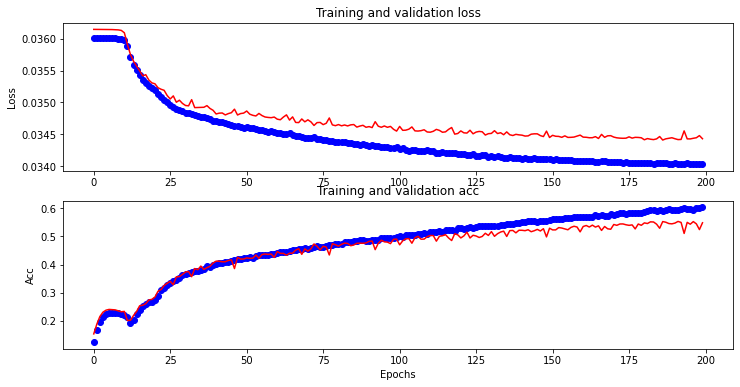

In [9]:
# plot learning curve
plt.figure(figsize = (12,6))

plt.subplot(2,1,1)
plt.plot(loss_values, 'bo', label='Training loss')
plt.plot(val_loss_values, 'r', label='Validation loss')
plt.title("Training and validation loss")
plt.ylabel('Loss')

plt.subplot(2,1,2)
plt.plot(acc_values, 'bo', label='Training acc')
plt.plot(val_acc_values, 'r', label='Validation acc')
plt.title("Training and validation acc")
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.show()